In [4]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, GRU
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.pyplot as plt


In [6]:
# Load the dataset
file_path = "weather.csv"  # Update with the correct path
df = pd.read_csv(file_path)

# Convert Date/Time to datetime and sort
df["Date/Time (LST)"] = pd.to_datetime(df["Date/Time (LST)"])
df = df.sort_values(by="Date/Time (LST)").reset_index(drop=True)

# Normalize numerical features
num_features = [
    "Temp (°C)", "Dew Point Temp (°C)", "Rel Hum (%)", "Wind Dir (10s deg)",
    "Wind Spd (km/h)", "Visibility (km)", "Stn Press (kPa)", "Hmdx", "Wind Chill", "temp change"
]
scaler = MinMaxScaler()
df[num_features] = scaler.fit_transform(df[num_features])

# Create sequences
SEQ_LENGTH = min(6, len(df) -1)  # Use 6 past hours to predict the next hour
feature_columns = df.columns.difference(["Date/Time (LST)", "temp change"]).tolist()

seq_data = df[feature_columns].to_numpy()
target_data = df["temp change"].to_numpy()

# Generate rolling sequences
X = np.lib.stride_tricks.sliding_window_view(seq_data, (SEQ_LENGTH, seq_data.shape[1])).squeeze(axis=1)
y = target_data[SEQ_LENGTH:]

# Time-Series Cross-Validation
tscv = TimeSeriesSplit(n_splits=5)
splits = [(train_idx, val_idx) for train_idx, val_idx in tscv.split(X)]

# Define RNN model function
def build_rnn_model(input_shape, num_units):
    model = Sequential([
        GRU(num_units, return_sequences=True),  # First GRU layer
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer="adam", loss="mse", metrics=["mae"])
    return model


def train_gru(number_of_units):
    adjusted_splits = [(train_idx[train_idx < len(y)], val_idx[val_idx < len(y)]) for train_idx, val_idx in splits]
    # Train and evaluate using time-series cross-validation
    history_list = []
    for fold, (train_idx, val_idx) in enumerate(adjusted_splits):
        if len(train_idx) == 0 or len(val_idx) == 0:
            print(f"Skipping fold {fold +1}: index out of bound")
            continue
        else:
            print(f"Training on fold {fold + 1}...")

        # Split data
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]

        # Build and train model
        model = build_rnn_model((SEQ_LENGTH, X.shape[2]), num_units=number_of_units)
        history = model.fit(X_train, y_train, validation_data=(X_val, y_val),
                            epochs=10, batch_size=32, verbose=1)
        
        # Save training history
        history_list.append(history)

    # Plot Training Loss
    plt.figure(figsize=(10, 5))
    for i, history in enumerate(history_list):
        plt.plot(history.history["loss"], label=f"Train Loss Fold {i+1}")
        plt.plot(history.history["val_loss"], label=f"Val Loss Fold {i+1}")

    plt.title("Training & Validation Loss Across Folds")
    plt.xlabel("Epochs")
    plt.ylabel("MSE Loss")
    plt.legend()
    plt.show()

training on 4 number of units
Training on fold 1...
Epoch 1/10
532/532 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0072 - mae: 0.0622 - val_loss: 0.0053 - val_mae: 0.0525
Epoch 2/10
532/532 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0059 - mae: 0.0546 - val_loss: 0.0053 - val_mae: 0.0521
Epoch 3/10
532/532 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0061 - mae: 0.0557 - val_loss: 0.0053 - val_mae: 0.0520
Epoch 4/10
532/532 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0059 - mae: 0.0547 - val_loss: 0.0053 - val_mae: 0.0522
Epoch 5/10
532/532 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0061 - mae: 0.0554 - val_loss: 0.0053 - val_mae: 0.0520
Epoch 6/10
532/532 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0060 - mae: 0.0550 - val_loss: 0.0053 - val_mae: 0.0525
Epoch 7/10
532/532 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0061 - mae: 0.0554 - val_loss: 0.0053 - val_mae: 0.0521
Epoch 8/10
532/532 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0060 - mae: 0.0551 - val_loss: 0.0053 - val_mae: 0.0520
Epoc

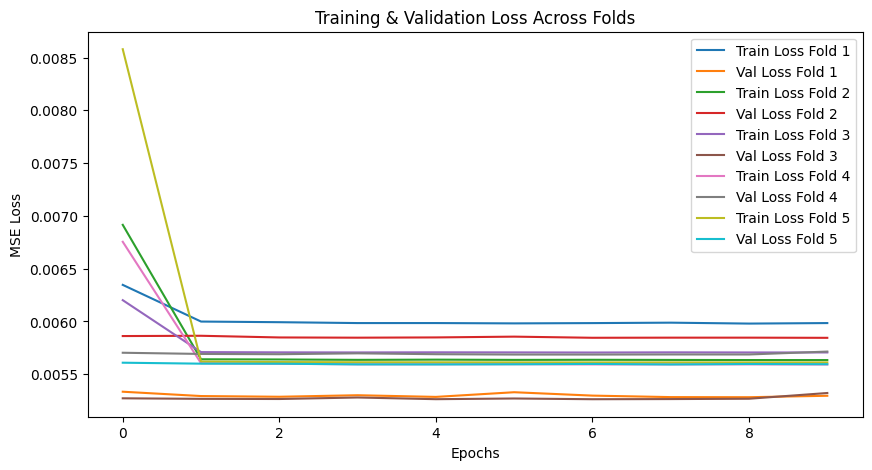

training on 8 number of units
Training on fold 1...
Epoch 1/10
532/532 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0062 - mae: 0.0572 - val_loss: 0.0053 - val_mae: 0.0523
Epoch 2/10
532/532 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0059 - mae: 0.0548 - val_loss: 0.0053 - val_mae: 0.0523
Epoch 3/10
532/532 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0062 - mae: 0.0556 - val_loss: 0.0053 - val_mae: 0.0524
Epoch 4/10
532/532 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0060 - mae: 0.0552 - val_loss: 0.0053 - val_mae: 0.0522
Epoch 5/10
532/532 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0061 - mae: 0.0556 - val_loss: 0.0053 - val_mae: 0.0521
Epoch 6/10
532/532 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0060 - mae: 0.0549 - val_loss: 0.0053 - val_mae: 0.0520
Epoch 7/10
532/532 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0058 - mae: 0.0548 - val_loss: 0.0053 - val_mae: 0.0520
Epoch 8/10
532/532 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0060 - mae: 0.0547 - val_loss: 0.0053 - val_mae: 0.0520
Epoc

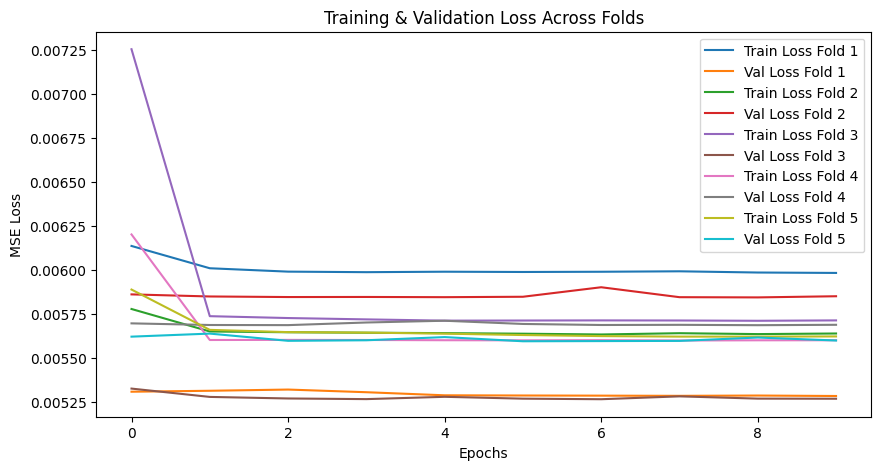

training on 16 number of units
Training on fold 1...
Epoch 1/10
532/532 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0063 - mae: 0.0571 - val_loss: 0.0053 - val_mae: 0.0524
Epoch 2/10
532/532 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0060 - mae: 0.0548 - val_loss: 0.0053 - val_mae: 0.0521
Epoch 3/10
532/532 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0060 - mae: 0.0551 - val_loss: 0.0053 - val_mae: 0.0521
Epoch 4/10
532/532 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0059 - mae: 0.0545 - val_loss: 0.0053 - val_mae: 0.0523
Epoch 5/10
532/532 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0060 - mae: 0.0549 - val_loss: 0.0053 - val_mae: 0.0520
Epoch 6/10
532/532 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0060 - mae: 0.0552 - val_loss: 0.0053 - val_mae: 0.0520
Epoch 7/10
532/532 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0059 - mae: 0.0549 - val_loss: 0.0053 - val_mae: 0.0521
Epoch 8/10
532/532 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0060 - mae: 0.0550 - val_loss: 0.0053 - val_mae: 0.0520
Epo

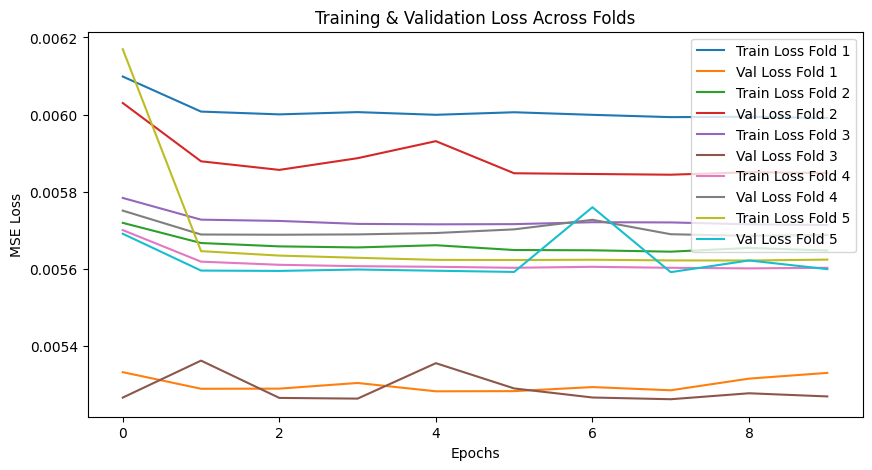

training on 32 number of units
Training on fold 1...
Epoch 1/10
532/532 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 0.0067 - mae: 0.0592 - val_loss: 0.0053 - val_mae: 0.0527
Epoch 2/10
532/532 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0063 - mae: 0.0565 - val_loss: 0.0053 - val_mae: 0.0523
Epoch 3/10
532/532 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0062 - mae: 0.0556 - val_loss: 0.0054 - val_mae: 0.0526
Epoch 4/10
532/532 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0062 - mae: 0.0562 - val_loss: 0.0053 - val_mae: 0.0522
Epoch 5/10
532/532 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0063 - mae: 0.0563 - val_loss: 0.0054 - val_mae: 0.0532
Epoch 6/10
532/532 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0060 - mae: 0.0552 - val_loss: 0.0053 - val_mae: 0.0521
Epoch 7/10
532/532 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0060 - mae: 0.0555 - val_loss: 0.0053 - val_mae: 0.0522
Epoch 8/10
532/532 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0061 - mae: 0.0558 - val_loss: 0.0053 - val_mae: 0.0521
Epo

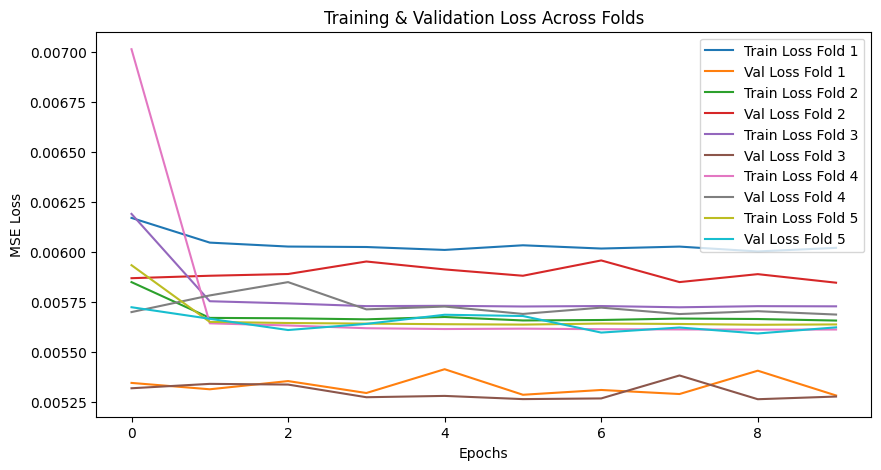

training on 64 number of units
Training on fold 1...
Epoch 1/10
532/532 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0080 - mae: 0.0644 - val_loss: 0.0053 - val_mae: 0.0524
Epoch 2/10
532/532 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0061 - mae: 0.0561 - val_loss: 0.0055 - val_mae: 0.0537
Epoch 3/10
532/532 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0061 - mae: 0.0561 - val_loss: 0.0053 - val_mae: 0.0521
Epoch 4/10
532/532 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0062 - mae: 0.0567 - val_loss: 0.0053 - val_mae: 0.0523
Epoch 5/10
532/532 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0060 - mae: 0.0552 - val_loss: 0.0053 - val_mae: 0.0522
Epoch 6/10
532/532 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0061 - mae: 0.0558 - val_loss: 0.0053 - val_mae: 0.0521
Epoch 7/10
532/532 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0060 - mae: 0.0557 - val_loss: 0.0053 - val_mae: 0.0521
Epoch 8/10
532/532 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0060 - mae: 0.0557 - val_loss: 0.0053 - val_mae: 0.0524
Epo

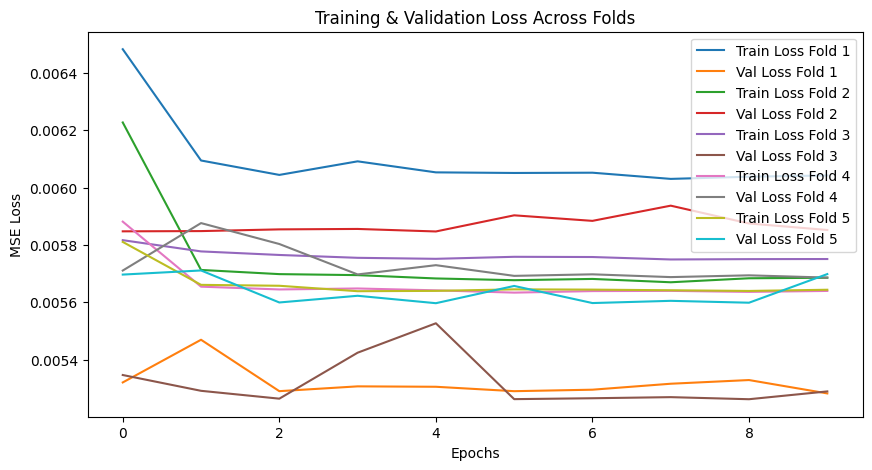

training on 128 number of units
Training on fold 1...
Epoch 1/10
532/532 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - loss: 0.0082 - mae: 0.0649 - val_loss: 0.0062 - val_mae: 0.0591
Epoch 2/10
532/532 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0062 - mae: 0.0565 - val_loss: 0.0058 - val_mae: 0.0563
Epoch 3/10
532/532 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0060 - mae: 0.0559 - val_loss: 0.0053 - val_mae: 0.0520
Epoch 4/10
532/532 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0059 - mae: 0.0553 - val_loss: 0.0053 - val_mae: 0.0521
Epoch 5/10
532/532 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0062 - mae: 0.0567 - val_loss: 0.0053 - val_mae: 0.0521
Epoch 6/10
532/532 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0063 - mae: 0.0566 - val_loss: 0.0053 - val_mae: 0.0520
Epoch 7/10
532/532 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0059 - mae: 0.0552 - val_loss: 0.0053 - val_mae: 0.0521
Epoch 8/10
532/532 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0059 - mae: 0.0551 - val_loss: 0.0057 - val_mae: 0.0552
Ep

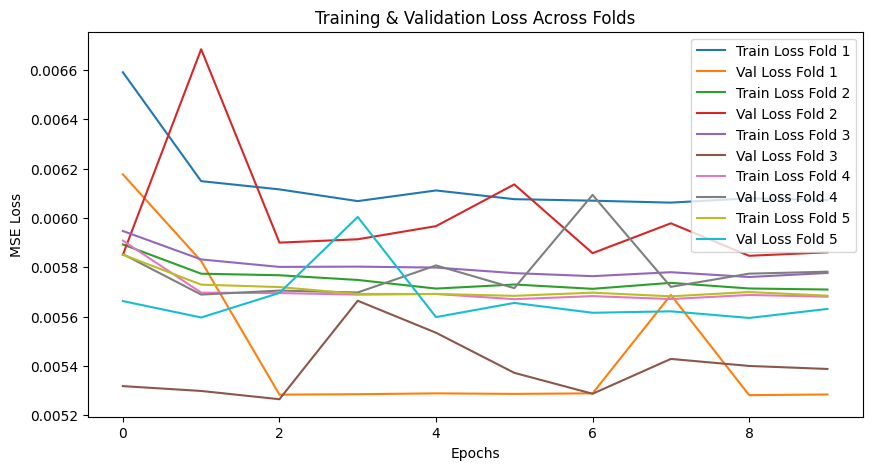

training on 256 number of units
Training on fold 1...
Epoch 1/10
532/532 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - loss: 0.0071 - mae: 0.0613 - val_loss: 0.0054 - val_mae: 0.0533
Epoch 2/10
532/532 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 0.0063 - mae: 0.0576 - val_loss: 0.0056 - val_mae: 0.0546
Epoch 3/10
532/532 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 0.0063 - mae: 0.0571 - val_loss: 0.0053 - val_mae: 0.0521
Epoch 4/10
532/532 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 0.0061 - mae: 0.0561 - val_loss: 0.0053 - val_mae: 0.0521
Epoch 5/10
532/532 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 0.0064 - mae: 0.0573 - val_loss: 0.0053 - val_mae: 0.0521
Epoch 6/10
532/532 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 0.0061 - mae: 0.0561 - val_loss: 0.0054 - val_mae: 0.0529
Epoch 7/10
532/532 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 0.0062 - mae: 0.0569 - val_loss: 0.0053 - val_mae: 0.0521
Epoch 8/10
532/532 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 0.0060 - mae: 0.0555 - val_loss: 0.0053 - val_mae: 0.052

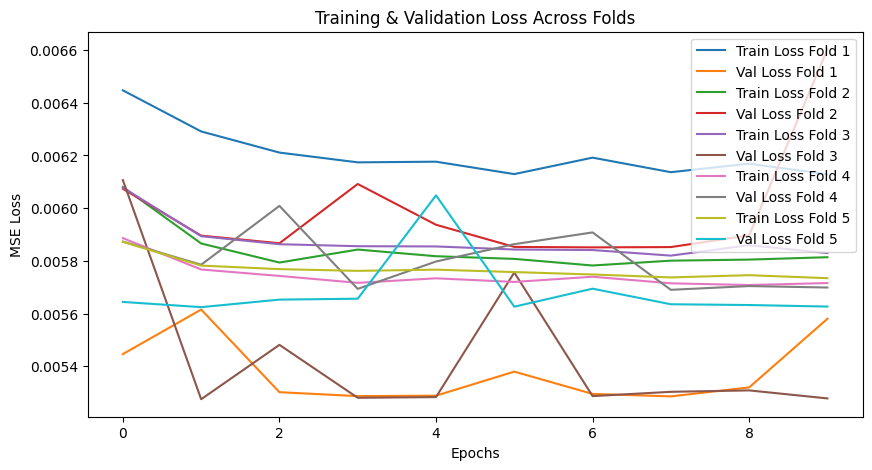

In [9]:
units_list = [4, 8, 16, 32, 64, 128, 256]
for i in range(len(units_list)):
    print("training on " + str(units_list[i]) + " number of units")
    train_gru(units_list[i])
